# IMDB 데이터를 이용한 과잉 적합의 구현과 해결

In [1]:
import numpy as numpy
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(train_X, train_y), (test_X, test_y) = tf.keras.datasets.imdb.load_data(num_words=1000)

In [3]:
def gen_one_hot(arr, dim=1000):
    results = numpy.zeros((len(arr), dim))
    for i, word_index in enumerate(arr):
        results[i, word_index] = 1.
    return results

train_X = gen_one_hot(train_X)
test_X = gen_one_hot(test_X)

## 과잉적합 모델 구축

In [4]:
model = tf.keras.Sequential()

**(input) Dense Layer**
- $1000$ vector $\Rightarrow$ $16$ vector
- $h$ = ReLU
- parameters: $16\,016$
  - $\#W = 16\,000$
  - $\#b = 16$

In [5]:
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(1000,)))

/opt/anaconda3/envs/ai-lecture-3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-16 22:38:45.456527: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-16 22:38:45.456558: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-16 22:38:45.456563: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-16 22:38:45.456581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-16 22:38:45.456594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271

In [6]:
model.add(tf.keras.layers.Dense(16, activation='relu'))

In [7]:
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │        16,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,305 (63.69 KB)

 Trainable params: 16,305 (63.69 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    train_X,
    train_y,
    epochs=20,
    batch_size=512,
    validation_data=(test_X, test_y),
    verbose=2
)

Epoch 1/20


2024-06-16 22:38:46.049447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


49/49 - 2s - 46ms/step - accuracy: 0.6775 - loss: 0.6108 - val_accuracy: 0.8085 - val_loss: 0.4697
Epoch 2/20
49/49 - 1s - 12ms/step - accuracy: 0.8395 - loss: 0.3855 - val_accuracy: 0.8535 - val_loss: 0.3489
Epoch 3/20
49/49 - 1s - 14ms/step - accuracy: 0.8660 - loss: 0.3255 - val_accuracy: 0.8576 - val_loss: 0.3347
Epoch 4/20
49/49 - 1s - 14ms/step - accuracy: 0.8722 - loss: 0.3097 - val_accuracy: 0.8591 - val_loss: 0.3295
Epoch 5/20
49/49 - 1s - 16ms/step - accuracy: 0.8767 - loss: 0.3028 - val_accuracy: 0.8588 - val_loss: 0.3291
Epoch 6/20
49/49 - 1s - 14ms/step - accuracy: 0.8780 - loss: 0.2988 - val_accuracy: 0.8583 - val_loss: 0.3315
Epoch 7/20
49/49 - 1s - 16ms/step - accuracy: 0.8786 - loss: 0.2958 - val_accuracy: 0.8558 - val_loss: 0.3364
Epoch 8/20
49/49 - 1s - 14ms/step - accuracy: 0.8781 - loss: 0.2943 - val_accuracy: 0.8584 - val_loss: 0.3324
Epoch 9/20
49/49 - 1s - 14ms/step - accuracy: 0.8802 - loss: 0.2886 - val_accuracy: 0.8585 - val_loss: 0.3303
Epoch 10/20
49/49 - 1

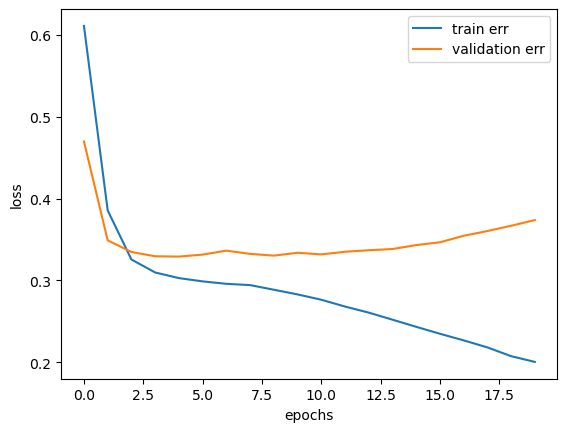

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']

epochs = range(1, len(accuracy) + 1)

plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train err', 'validation err'])
plt.show()

## 가중치 규제항 추가

가중치의 값이 너무 크면, 판단 경계선이 복잡해지고 과잉 적합이 발생함

$\Rightarrow$ 가중치 규제

- L1 규제: $Loss = Cost + \lambda \Sigma |W|$
- L2 규제: $Loss = Cost + \lambda \Sigma W^2$

In [11]:
model = tf.keras.Sequential()

In [12]:
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(.001), input_shape=(1000, )))
model.add(tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(.001), activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [13]:
model.compile()

Epoch 1/20


/opt/anaconda3/envs/ai-lecture-3.10/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['bias', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


49/49 - 1s - 11ms/step - loss: 0.0389 - val_loss: 0.0302
Epoch 2/20
49/49 - 0s - 4ms/step - loss: 0.0242 - val_loss: 0.0189
Epoch 3/20
49/49 - 0s - 5ms/step - loss: 0.0152 - val_loss: 0.0118
Epoch 4/20
49/49 - 0s - 4ms/step - loss: 0.0095 - val_loss: 0.0073
Epoch 5/20
49/49 - 0s - 5ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 6/20
49/49 - 0s - 5ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 7/20
49/49 - 0s - 5ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 8/20
49/49 - 0s - 5ms/step - loss: 0.0012 - val_loss: 9.1768e-04
Epoch 9/20
49/49 - 0s - 5ms/step - loss: 7.0349e-04 - val_loss: 5.1591e-04
Epoch 10/20
49/49 - 0s - 5ms/step - loss: 3.9241e-04 - val_loss: 2.8521e-04
Epoch 11/20
49/49 - 0s - 5ms/step - loss: 2.1574e-04 - val_loss: 1.5584e-04
Epoch 12/20
49/49 - 0s - 5ms/step - loss: 1.1746e-04 - val_loss: 8.4520e-05
Epoch 13/20
49/49 - 0s - 5ms/step - loss: 6.3571e-05 - val_loss: 4.5639e-05
Epoch 14/20
49/49 - 0s - 5ms/step - loss: 3.4285e-05 - val_loss: 2.4582e-05
Epoch 15/20
49/

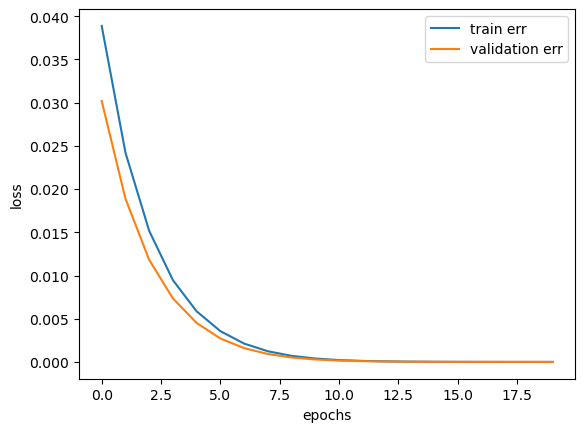

In [14]:
history = model.fit(
    train_X,
    train_y,
    epochs=20,
    batch_size=512,
    validation_data=(test_X, test_y),
    verbose=2
)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train err', 'validation err'])
plt.show()